# Google Vertex AI Feature Store

> [Google Cloud Vertex Feature Store](https://cloud.google.com/vertex-ai/docs/featurestore/latest/overview) streamlines your ML feature management and online serving processes by letting you serve at low-latency your data in [Google Cloud BigQuery](https://cloud.google.com/bigquery?hl=en), including the capacity to perform approximate neighbor retrieval for embeddings


This tutorial shows you how to easily perform low-latency vector search and approximate nearest neighbor retrieval directly from your BigQuery data, enabling powerful ML applications with minimal setup. We will do that using the `VertexFSVectorStore` class. 

This class is part of a set of 2 classes capable of providing a unified data storage and flexible vector search in Google Cloud:
- **BigQuery Vector Search**: with `BigQueryVectorStore` class, which is ideal for rapid prototyping with no infrastructure setup and batch retrieval.
- **Feature Store Online Store**: with `VertexFSVectorStore` class, enables low-latency retrieval with manual or scheduled data sync. Perfect for production-ready user-facing GenAI applications.


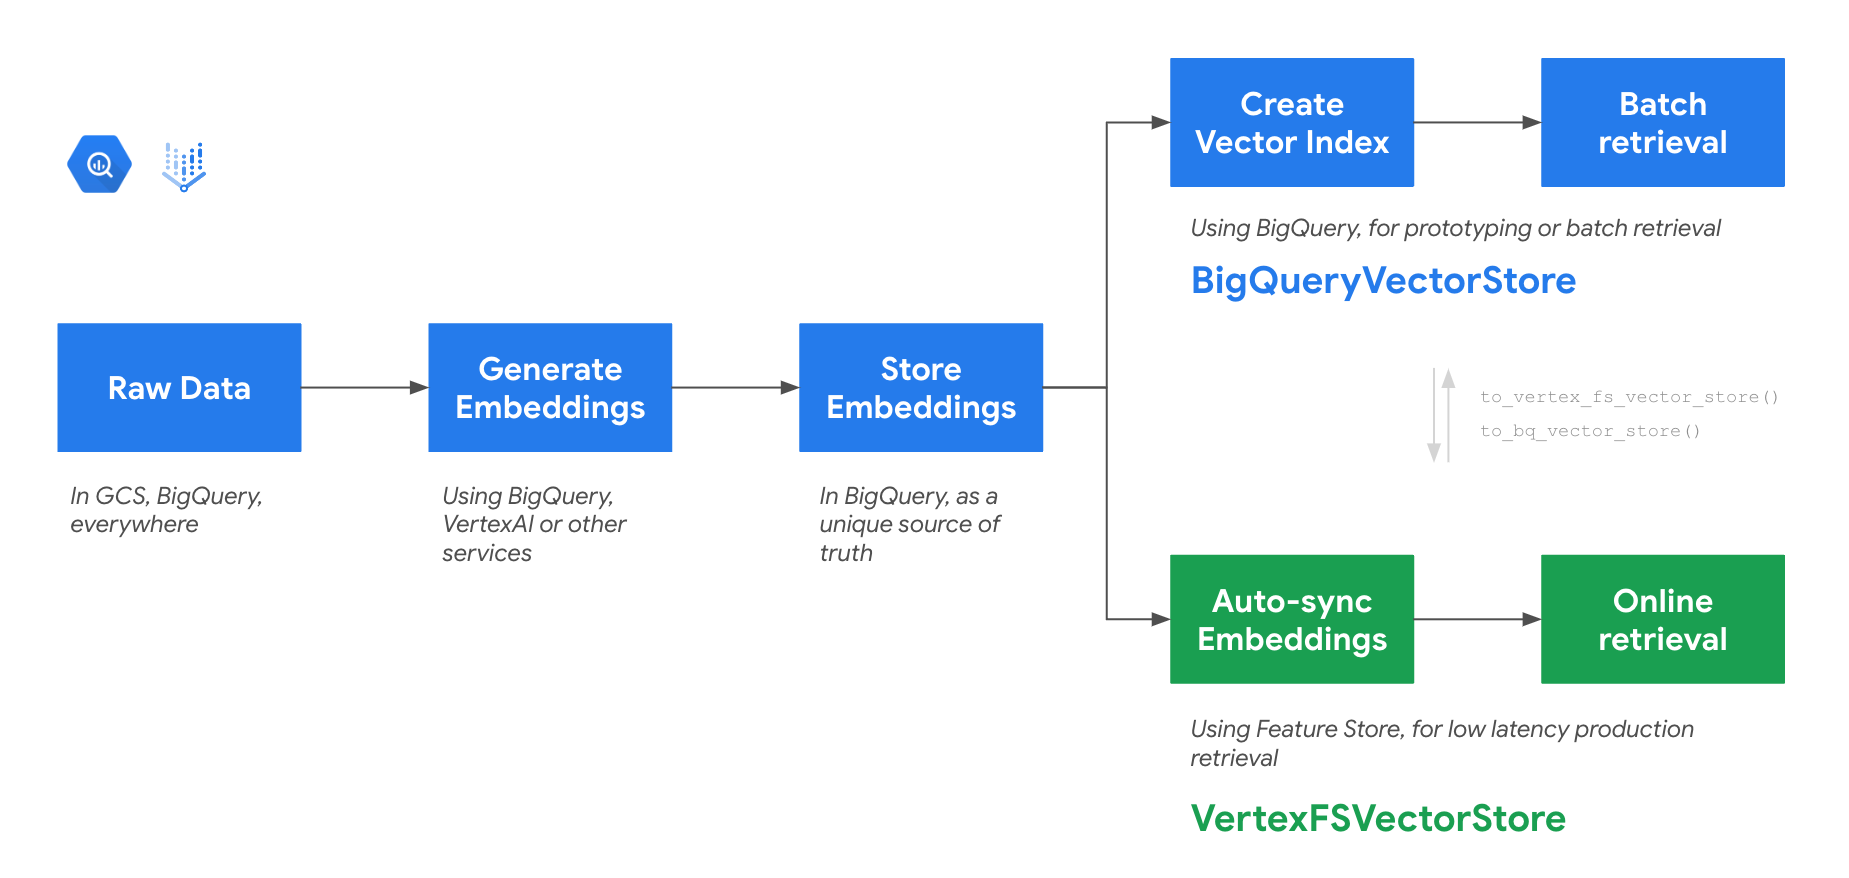

## Getting started


### Install the library

In [ ]:
%pip install --upgrade --quiet  langchain langchain-google-vertexai "langchain-google-community[featurestore]"

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Before you begin

#### Set your project ID

If you don't know your project ID, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113).

In [ ]:
PROJECT_ID = ""  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

#### Set the region

You can also change the `REGION` variable used by BigQuery. Learn more about [BigQuery regions](https://cloud.google.com/bigquery/docs/locations#supported_locations).

In [ ]:
REGION = "us-central1"  # @param {type: "string"}

#### Set the dataset and table names

They will be your BigQuery Vector Store.

In [ ]:
DATASET = "my_langchain_dataset"  # @param {type: "string"}
TABLE = "doc_and_vectors"  # @param {type: "string"}

### Authenticating your notebook environment

- If you are using **Colab** to run this notebook, uncomment the cell below and continue.
- If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [ ]:
# from google.colab import auth as google_auth

# google_auth.authenticate_user()

## Demo: VertexFSVectorStore

### Create an embedding class instance

You may need to enable Vertex AI API in your project by running
`gcloud services enable aiplatform.googleapis.com --project {PROJECT_ID}`
(replace `{PROJECT_ID}` with the name of your project).

You can use any [LangChain embeddings model](/docs/integrations/text_embedding/).

In [ ]:
from langchain_google_vertexai import VertexAIEmbeddings

embedding = VertexAIEmbeddings(
    model_name="textembedding-gecko@latest", project=PROJECT_ID
)

### Initialize VertexFSVectorStore

BigQuery Dataset and Table will be automatically created if they do not exist. See class definition [here](https://github.com/langchain-ai/langchain-google/blob/main/libs/community/langchain_google_community/bq_storage_vectorstores/featurestore.py#L33) for all optional paremeters.

In [ ]:
from langchain_google_community import VertexFSVectorStore

store = VertexFSVectorStore(
    project_id=PROJECT_ID,
    dataset_name=DATASET,
    table_name=TABLE,
    location=REGION,
    embedding=embedding,
)

### Add texts

> Note: The first synchronization process will take around ~20 minutes because of Feature Online Store creation.

In [ ]:
all_texts = ["Apples and oranges", "Cars and airplanes", "Pineapple", "Train", "Banana"]
metadatas = [{"len": len(t)} for t in all_texts]

store.add_texts(all_texts, metadatas=metadatas)

You can also start a sync on demand by executing the `sync_data` method.

In [ ]:
store.sync_data()

When in a production environment, you can also use `cron_schedule` class parameter to setup an automatic scheduled synchronization. 
For example:
```python
store = VertexFSVectorStore(cron_schedule="TZ=America/Los_Angeles 00 13 11 8 *", ...)
```

### Search for documents

In [ ]:
query = "I'd like a fruit."
docs = store.similarity_search(query)
print(docs)

### Search for documents by vector

In [ ]:
query_vector = embedding.embed_query(query)
docs = store.similarity_search_by_vector(query_vector, k=2)
print(docs)

### Search for documents with metadata filter

In [ ]:
# This should only return "Banana" document.
docs = store.similarity_search_by_vector(query_vector, filter={"len": 6})
print(docs)

### Add text with embeddings

You can also bring your own embeddings with the`add_texts_with_embeddings` method.
This is particularly useful for multimodal data which might require custom preprocessing before the embedding generation.

In [ ]:
items = ["some text"]
embs = embedding.embed(items)

ids = store.add_texts_with_embeddings(
    texts=["some text"], embs=embs, metadatas=[{"len": 1}]
)

### Batch serving with BigQuery
You can simply use the method `.to_bq_vector_store()` to get a BigQueryVectorStore object, which offers optimized performances for batch use cases. All mandatory parameters will be automatically transferred from the existing class. See the [class definition](https://github.com/langchain-ai/langchain-google/blob/main/libs/community/langchain_google_community/bq_storage_vectorstores/bigquery.py#L26) for all the parameters you can use.

Moving back to BigQueryVectorStore is equivalently easy with the `.to_vertex_fs_vector_store()` method.

In [ ]:
store.to_bq_vector_store()  # pass optional VertexFSVectorStore parameters as arguments